In [1]:
import time
import pandas as pd
from IPython.display import display, HTML
import random
import math
import matplotlib.pyplot as plt

def read_data(file_path):
    with open(file_path, 'r') as file:
        length = None
        num_employees = None
        num_shifts = None
        temporal_requirements = []
        shift_data = []
        min_days_off = None
        max_days_off = None
        min_work_blocks = None
        max_work_blocks = None
        num_sequences_of_length_2 = None
        num_sequences_of_length_3 = None
        forbidden_sequences = []

        for line in file:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            if length is None:
                length = int(line)
            elif num_employees is None:
                num_employees = int(line)
            elif num_shifts is None:
                num_shifts = int(line)
            elif len(temporal_requirements)<num_shifts:
                temporal_requirements.append(line.split())
            elif len(shift_data)<num_shifts:
                # Dividir la línea en palabras
                words = line.split()
                # Obtener el nombre del turno y los demás datos
                shift_name = words[0]
                start_time = int(words[1])
                lengthT = int(words[2])
                employee_requirements = list(map(int, words[3:]))
                # Agregar los datos a la lista de turnos
                shift_data.append({
                    "name": shift_name,
                    "start_time": start_time,
                    "lengthT": lengthT,
                    "employee_requirements": employee_requirements})
            elif min_days_off is None:
                min_days_off, max_days_off = map(int, line.split())
            elif min_work_blocks is None:
                min_work_blocks, max_work_blocks = map(int, line.split())
            elif num_sequences_of_length_2 is None:
                num_sequences_of_length_2, num_sequences_of_length_3 = map(int, line.split())
            else:
                forbidden_sequences.append(line.split())
        data={
            "length": length,
            "num_employees": num_employees,
            "num_shifts": num_shifts,
            "temporal_requirements": temporal_requirements,
            "shift_data": shift_data,
            "min_days_off": min_days_off,
            "max_days_off": max_days_off,
            "min_work_blocks": min_work_blocks,
            "max_work_blocks": max_work_blocks,
            "num_sequences_of_length_2": num_sequences_of_length_2,
            "num_sequences_of_length_3": num_sequences_of_length_3,
            "forbidden_sequences": forbidden_sequences
             }
        print(data)
        return data

##  FUNCIONES  ###############################################################################################################

def evaluar_satisfaccion(asig): 
    puntaje = 0
    satisfechos=0
    indiferentes=0
    insatisfechos=0
    for tipo,dia,req in turnos:
        if preferencias[asig[tipo,dia,req][0]][0]==tipo:
            puntaje +=1
            satisfechos+=1
        elif preferencias[asig[tipo,dia,req][0]][1]==tipo:
            puntaje +=-1
            insatisfechos+=1
        else:
            indiferentes+=1
    return puntaje,satisfechos,indiferentes,insatisfechos

def RCL(tipo, lista, trab ,alpha):
    categorias = [[] for i in range(3)]
    personas = []
    minimo = 99999
    maximo = -1
    for i in lista:
        if trab[i]<minimo:
            minimo=trab[i]
        if trab[i]>maximo:
            maximo=trab[i]
    for i in lista:
        if trab[i]<=math.ceil(minimo+alpha*(maximo-minimo)):
            personas.append(i)
    
    for p in range(len(personas)):
        if preferencias[personas[p]][0]==tipo:
            categorias[0].append(personas[p])
        elif preferencias[personas[p]][1]==tipo:
            categorias[2].append(personas[p])
        else:
            categorias[1].append(personas[p])
    
    return categorias

def act_proh(turns):
    proh = {(i,j):[] for i in range(data['length']) for j in tipo_turnos}
    turnoss=turns.copy()
    for tipo,dia,requerimiento in turnoss:
        elegido = turnoss[tipo,dia,requerimiento]
        if dia == 0:
            for k in range(len(data['forbidden_sequences'])):
                if data['forbidden_sequences'][k][0]==tipo:
                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
        elif dia == data['length']-1:
            for k in range(len(data['forbidden_sequences'])):
                if data['forbidden_sequences'][k][1]==tipo:
                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)            
        else:
            for k in range(len(data['forbidden_sequences'])):
                if data['forbidden_sequences'][k][0]==tipo:
                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                if data['forbidden_sequences'][k][1]==tipo:
                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)
    return proh

def revisar_proh(turns):
    proh = {(i,j):[] for i in range(data['length']) for j in tipo_turnos}
    turnoss=turns.copy()
    for tipo,dia,requerimiento in turnoss:
        elegido = turnoss[tipo,dia,requerimiento]
        if dia == 0:
            for k in range(len(data['forbidden_sequences'])):
                if data['forbidden_sequences'][k][0]==tipo:
                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
        elif dia == data['length']-1:
            for k in range(len(data['forbidden_sequences'])):
                if data['forbidden_sequences'][k][1]==tipo:
                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)            
        else:
            for k in range(len(data['forbidden_sequences'])):
                if data['forbidden_sequences'][k][0]==tipo:
                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                if data['forbidden_sequences'][k][1]==tipo:
                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)
    respuesta=0
    for tipo,dia,requerimiento in turnoss:
        if turnoss[tipo,dia,requerimiento] in proh[dia,tipo] and turnoss[tipo,dia,requerimiento]!=-1 :
            respuesta+=1
            #print( turnoss[tipo,dia,requerimiento]+1,tipo,dia)
    return respuesta
    
##  CONSTRUCTIVO  ###############################################################################################################

def constructivo(alpha,reparar):
    #CONSTRUCCIÓN
    t = {i:-1 for i in turnos}
    trabajados = [0 for conductor in conductores.copy()]
    ddia = {i:conductores.copy() for i in range(data['length'])}
    proh = {(i,j):[] for i in range(data['length']) for j in tipo_turnos}
    
    agrego=True
    obj=0
    v=0
    itera=0
    
    g=[[] for i in range(3)]
    
    while agrego==True:
        agrego=False
        for tipo,dia,requerimiento in t:
            if t[tipo,dia,requerimiento] ==-1:
                lista=RCL(tipo,ddia[dia],trabajados,alpha)[v]
                if len(lista)>0:
                    elegido = random.choice(lista)
                    if elegido not in proh[dia,tipo]:#and trabajados[elegido]<=maximo_final-1:
                        t[tipo,dia,requerimiento]=elegido
                        trabajados[elegido]+=1
                        ddia[dia].remove(elegido)
                        agrego=True
                        if tipo==preferencias[elegido][0]:
                            obj+=1
                        elif tipo==preferencias[elegido][1]:
                            obj+=-1
                        
                        itera+=1
                        g[0].append(obj)
                        g[1].append(itera)
                        if max(trabajados)>maximo_final:
                            g[2].append(1)
                        else:
                            g[2].append(0)
                        
                        if dia == 0:
                            for k in range(len(data['forbidden_sequences'])):
                                if data['forbidden_sequences'][k][0]==tipo:
                                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                        elif dia == data['length']-1:
                            for k in range(len(data['forbidden_sequences'])):
                                if data['forbidden_sequences'][k][1]==tipo:
                                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)            
                        else:
                            for k in range(len(data['forbidden_sequences'])):
                                if data['forbidden_sequences'][k][0]==tipo:
                                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                                elif data['forbidden_sequences'][k][1]==tipo:
                                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)
                        
        if agrego==False and v<2:
            agrego=True
            v+=1
    #REPARACIÓN NO ASIGNADOS
    hizo=False
    if sum(trabajados)<len(t) and sum(trabajados)>=alpha*len(t) and reparar==True:
        hizo=True
        for tipo,dia,requerimiento in t:
            if t[tipo,dia,requerimiento] ==-1:
                reparo=False
                for elegido in ddia[dia]:
                    if elegido not in proh[dia,tipo]:
                        t[tipo,dia,requerimiento]=elegido
                        trabajados[elegido]+=1
                        ddia[dia].remove(elegido)
                        agrego=True
                        if tipo==preferencias[elegido][0]:
                            obj+=1
                        elif tipo==preferencias[elegido][1]:
                            obj+=-1
                        
                        reparo=True
                        itera+=1
                        g[0].append(obj)
                        g[1].append(itera)
                        if max(trabajados)>maximo_final:
                            g[2].append(1)
                        else:
                            g[2].append(0)
                        
                        if dia == 0:
                            for k in range(len(data['forbidden_sequences'])):
                                if data['forbidden_sequences'][k][0]==tipo:
                                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                        elif dia == data['length']-1:
                            for k in range(len(data['forbidden_sequences'])):
                                if data['forbidden_sequences'][k][1]==tipo:
                                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)            
                        else:
                            for k in range(len(data['forbidden_sequences'])):
                                if data['forbidden_sequences'][k][0]==tipo:
                                    proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                                elif data['forbidden_sequences'][k][1]==tipo:
                                    proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)
                        break
                if reparo==False:
                    break
    r=0            
    if hizo==True:
        if sum(trabajados)==len(t):
            r=1
        else:
            r=2
    if hizo==False:
        if sum(trabajados)<len(t):
            r=3
        
    #BALANCEO EXCESO TRABAJO
    falta = []
    completo = []
    excede = []
    for i in conductores:
        if trabajados[i]<maximo_final:
            falta.append(i)
        elif trabajados[i]==maximo_final:
            completo.append(i)
        else:
            excede.append(i)
    cambio=True
    while cambio ==True and sum(trabajados)==len(t):
        cambio=False
        for tipo,dia,requerimiento in t:
            actual=t[tipo,dia,requerimiento]
            if actual in excede:
                elegido=random.choice(falta)
                if elegido in ddia[dia] and elegido not in proh[dia,tipo]:
                    t[tipo,dia,requerimiento]=elegido
                    trabajados[elegido]+=1
                    trabajados[actual]+=-1
                    ddia[dia].remove(elegido)
                    ddia[dia].append(actual)
                    agrego=True
                    if tipo==preferencias[actual][0]:
                        if tipo!=preferencias[elegido][0]:
                            if tipo==preferencias[elegido][1]:
                                obj+=-2
                            else:
                                obj+=-1
                    elif tipo==preferencias[actual][1]:
                        if tipo!=preferencias[elegido][1]:
                            if tipo==preferencias[elegido][0]:
                                obj+=2
                            else:
                                obj+=1
                    else:
                        if tipo==preferencias[elegido][0]:
                            obj+=1
                        elif tipo==preferencias[elegido][1]:
                            obj+=-1
                            
                    itera+=1
                    g[0].append(obj)
                    g[1].append(itera)
                    if max(trabajados)>maximo_final:
                        g[2].append(1)
                    else:
                        g[2].append(0)
                    
                    if dia == 0:
                        for k in range(len(data['forbidden_sequences'])):
                            if data['forbidden_sequences'][k][0]==tipo:
                                proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                    elif dia == data['length']-1:
                        for k in range(len(data['forbidden_sequences'])):
                            if data['forbidden_sequences'][k][1]==tipo:
                                proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)            
                    else:
                        for k in range(len(data['forbidden_sequences'])):
                            if data['forbidden_sequences'][k][0]==tipo:
                                proh[dia+1,data['forbidden_sequences'][k][1]].append(elegido)
                            elif data['forbidden_sequences'][k][1]==tipo:
                                proh[dia-1,data['forbidden_sequences'][k][0]].append(elegido)
                    if trabajados[elegido]==maximo_final:
                        completo.append(elegido)
                        falta.remove(elegido)
                    if trabajados[actual]==maximo_final:
                        completo.append(actual)
                        excede.remove(actual)
                    cambio=True
                        
    return t,trabajados,sum(trabajados),obj,g,r

##  BUSQUEDA LOCAL ##############################################################################################################################

def busqueda_local(turns,obj,trab,g):
    proh=act_proh(turns)
    ddia = {i:conductores.copy() for i in range(data['length'])}
    for t,d,r in turns:
        if turns[t,d,r] in ddia[d]:
            ddia[d].remove(turns[t,d,r])
    mejoro = True
    while mejoro==True:
        mejoro = False
        itera=max(g[1])
        for t,d,r in turns:
            elec=turns[t,d,r]
            si=preferencias[elec][0]
            no=preferencias[elec][1]

            ####################  INSERT  ##########################
            for c in conductores.copy():
                if c!=elec:
                    if trab[c]<=maximo_final-1 and c not in proh[d,t] and c in ddia[d] and trab[elec]>=maximo_inicial+1:
                        mejora=0
                        mejora1=0
                        sic=preferencias[c][0]
                        noc=preferencias[c][1]
                        if si==t:
                            mejora+=1
                        elif no==t:
                            mejora+=-1
                        if sic==t:
                            mejora1+=1
                        elif noc==t:
                            mejora1+=-1

                        if mejora1>mejora:
                                obj+=mejora1-mejora
                                mejoro = True
                                turns[t,d,r]=c
                                ddia[d].remove(c)
                                ddia[d].append(elec)
                                trab[elec]+=-1
                                trab[c]+=1
                                #Actualiza prohibidos
                                proh=act_proh(turns)
                                #print("INSERT",c,"-->",obj)
                                elec=c
                                si=preferencias[elec][0]
                                no=preferencias[elec][1]
                                
                                itera+=1
                                g[0].append(obj)
                                g[1].append(itera)
                                g[2].append(0)
                                
                                break

            ####################  SWAP  ##########################
            for t1,d1,r1 in turns:
                if  (t!=t1 or(t==t1 and d==d1)):
                    elec1=turns[t1,d1,r1]
                    if elec in ddia[d1] and elec1 in ddia[d]:
                        if elec not in proh[d1,t1] and elec1 not in proh[d,t]:
                            si1=preferencias[elec1][0]
                            no1=preferencias[elec1][1]
                            mejora = 0
                            if si==t1:
                                if si!=t:
                                    if no==t:
                                        mejora+=2
                                    else:
                                        mejora+=1
                            elif no==t1:
                                if no!=t:
                                    if si==t:
                                        mejora+=-2
                                    else:
                                        mejora+=-1
                            else:
                                if si==t:
                                    mejora+=-1
                                else:
                                    mejora+=1

                            if si1==t:
                                if si1!=t1:
                                    if no1==t1:
                                        mejora+=2
                                    else:
                                        mejora+=1
                            elif no1==t:
                                if no1!=t1:
                                    if si1==t1:
                                        mejora+=-2
                                    else:
                                        mejora+=-1
                            else:
                                if si1==t1:
                                    mejora+=-1
                                else:
                                    mejora+=1
                            if mejora>0:
                                obj+=mejora
                                mejoro = True
                                turns[t,d,r]=elec1
                                turns[t1,d1,r1]=elec
                                ddia[d].remove(elec1)
                                ddia[d].append(elec)
                                ddia[d1].remove(elec)
                                ddia[d1].append(elec1)
                                #Actualiza prohibidos
                                proh=act_proh(turns)
                                #print("SWAP",elec,elec1,"-->",obj)
                                itera+=1
                                g[0].append(obj)
                                g[1].append(itera)
                                g[2].append(0)
                                break
    return turns, obj,trab,g

##  GRASP  ###############################################################################################################

def GRASP(itera,alpha,umbral):
    max_v=0
    max_t=[]
    r0=0
    r1=0
    r2=0
    r3=0
    max_tiempo=0
    reparar=False
    inicio=time.time()
    for i in range(itera):
        #print(i+1)
        if i>=itera*umbral and max_t==[]:
            reparar=True
        inicio_constructivo=time.time()
        t=constructivo(alpha,reparar)
        tiempo_constructivo=inicio_constructivo-time.time()
        if t[5]==0:
            r0+=1
        elif t[5]==1:
            r1+=1
        elif t[5]==2:
            r2+=1
        else:
            r3+=1
        if sum(t[1])==len(t[0]):
            asignacion = {}
            for turno in t[0]:
                asignacion[turno]=(t[0][turno],turno)
            #v=evaluar_satisfaccion(asignacion)
            v=t[3]
            inicio_bl=time.time()
            t1=busqueda_local(t[0],v,t[1],t[4])
            tiempo_bl=inicio_bl-time.time()
            if t1[1]>max_v and max(t1[2])<=maximo_final:
                max_v=t1[1]
                max_t=[t,t1,v]
                max_tiempo=(tiempo_constructivo,tiempo_bl)
    
    D = round(time.time()-inicio,2)

    return max_v,max_t,r0,r1,r2,r3,D,max_tiempo

def graficar(max_v,max_t,r0,r1,r2,r3,D):
    M=[]
    M.append(r0)
    M.append(r3)
    M.append(r1)
    M.append(r2)
    tabla = pd.DataFrame(M).transpose().rename(columns={0:'Exitosas',1:'No exitosas',2:'Reparadas',3:'Reparación fallida'})
    tabla.reset_index(drop=True, inplace=True)
    estilos = [    dict(selector="th", props=[("border", "1px solid black")]),
        dict(selector="td", props=[("border", "1px solid black")])
    ]
    tabla = tabla.rename(index={0: '#'})
    tabla_estilizada = tabla.style.set_table_styles(estilos)
    display(HTML(tabla_estilizada.render()))
    
    for j in max_t[1][0]:
        if max_t[1][0][j]==-1:
            "falta turnos por asignar"
    asignacion = {}
    for turno in max_t[1][0]:
        asignacion[turno]=(max_t[1][0][turno],turno)
    v=evaluar_satisfaccion(asignacion)
    satisfechos=v[1]
    indiferentes=v[2]
    insatisfechos=v[3]
    M=[]
    M.append(str(D))
    M.append(max_t[2])
    M.append(max_t[1][1])
    M.append(str(round(max_t[1][1]/max_t[0][2]*100,2))+' %')
    M.append(str(round(satisfechos/max_t[0][2]*100,2))+' %')
    M.append(str(round(indiferentes/max_t[0][2]*100,2))+' %')
    M.append(str(round(insatisfechos/max_t[0][2]*100,2))+' %')
    tabla = pd.DataFrame(M).transpose().rename(columns={0:'Tiempo (s)',1:'Puntaje Constructivo',2:'Puntaje Busqueda Local',3:'Satisfacción Global',4:'Satisfechos',5:'Indiferentes',6:'Insatisfechos'})
    tabla.reset_index(drop=True, inplace=True)
    estilos = [    dict(selector="th", props=[("border", "1px solid black")]),
        dict(selector="td", props=[("border", "1px solid black")])
    ]
    tabla = tabla.rename(index={0: 'Estadisticas'})
    tabla_estilizada = tabla.style.set_table_styles(estilos)
    display(HTML(tabla_estilizada.render()))
    print("----------------------------------------------")
    print(revisar_proh(max_t[1][0]),"Errores de secuencias prohibidas")
    print(sum(max_t[0][1]),"de",max_t[0][2],"turnos asignados")
    print("# Dias de trabajo  (min y max):",min(max_t[0][1]),"-",max(max_t[0][1]),"(",data['min_work_blocks'],"-",data['max_work_blocks'],")")
    print("# Dias de descanso (min y max):",data['length']-max(max_t[0][1]),"-",data['length']-min(max_t[0][1]),"(",data['min_days_off'],"-",data['max_days_off'],")")
    print("----------------------------------------------")
    
    M=[]
    for i in range(data['num_employees']):
        c=["-" for i in range(data['length'])]
        for d1 in range(data['length']):
            for t,d,r in max_t[1][0]:
                if max_t[1][0][t,d,r]==i and d1==d:
                    if c[d1]!="-":
                        print("********************ERROR********************")
                    c[d1]=t
                    break
        M.append(c)

    tabla = pd.DataFrame(M,columns=["L","M", "X", "J", "V", "S", "D"])
    tabla_con_indices = tabla.set_index(pd.Index(["EMPLEADO "+str(i+1) for i in range(data['num_employees'])]))
    estilos = [    dict(selector="th", props=[("border", "1px solid black")]),
        dict(selector="td", props=[("border", "1px solid black")])
    ]
    tabla_estilizada = tabla_con_indices.style.set_table_styles(estilos)

    display(HTML(tabla_estilizada.render()))
    
    print("\n\n\n")
    colors = ['red' if max_t[1][3][2][i] == 1 else 'gray' for i in range(len(max_t[1][3][2]))]
    T=len(max_t[1][3][1]) - 1
    plt.figure(figsize=(10, 7))
    anterior='gray'
    for i in range(T):
        if i==T-1:
            plt.plot([max_t[1][3][1][i], max_t[1][3][1][i+1]], [max_t[1][3][0][i], max_t[1][3][0][i+1]], color=colors[i+1])
            plt.annotate(max_t[1][3][0][i+1], xy=(max_t[1][3][1][i+1], max_t[1][3][0][i+1]), xytext=(max_t[1][3][1][i+1], max_t[1][3][0][i+1]), fontsize=11,color=colors[i+1])
        else:
            plt.plot([max_t[1][3][1][i], max_t[1][3][1][i+1]], [max_t[1][3][0][i], max_t[1][3][0][i+1]], color=colors[i])

    #plt.scatter(max_t[1][3][1], max_t[1][3][0],color=colors,s=15) 
    plt.plot(max_t[1][3][1],[len(max_t[1][0]) for i in range(T+1)], color='blue', linestyle='--')
    plt.annotate(len(max_t[1][0]), xy=(max_t[1][3][1][T], len(max_t[1][0])), xytext=(max_t[1][3][1][T], len(max_t[1][0])), fontsize=11,color='blue')

    
    plt.title("Comportamiento Puntaje mejor solución")
    plt.ylabel("PUNTAJE")
    plt.xticks([])
    line_red=plt.Line2D((0, 1), (0, 0), color='red', marker='o', linestyle='')
    line_green=plt.Line2D((0, 1), (0, 0), color='gray', marker='o', linestyle='')
    plt.legend([line_red, line_green], ["Infactible", 'Factible'], loc='lower right')
    plt.show()



In [2]:
##  CARGA DE DATOS Y PARAMETROS  ###############################################################################################################

%cd "C:/Users/horse/Documents/X Semestre/Proyecto de grado/TESIS_DAVID_PARDO/Instancias/"

instancia="Example1.txt"
#instancia="integra_troncal.txt"
data = read_data(instancia)


tipo_turnos=[]
for i in range(len(data['shift_data'])):
    tipo_turnos.append(data['shift_data'][i]['name'])
    
preferencias = {}
if instancia != "integra_troncal.txt":
    generador = random.Random()
    generador.seed(9)
    for conductor in range(data['num_employees']):
        le_gusta = generador.choice(tipo_turnos)
        tipo_turnos1=tipo_turnos.copy()
        tipo_turnos1.remove(le_gusta)
        no_le_gusta = generador.choice(tipo_turnos1)
        preferencias[conductor] = [le_gusta,no_le_gusta]
else:
    preferencias = {0:['D','N'],1:['D','N'],2:['N','D'],3:['D','M'],4:['N','D'],5:['M','N'],6:['M','D'],7:['D','M'],8:['N','D'],9:['N','D'],10:['M','D'],11:['N','D'],12:['N','D'],13:['N','D'],14:['D','M'],15:['N','M'],16:['D','N'],17:['M','D'],18:['N','M'],19:['N','M'],20:['D','N'],21:['M','D'],22:['D','N'],23:['D','N'],24:['D','N'],25:['M','D'],26:['M','D'],27:['N','D'],28:['D','N'],29:['N','D'],30:['M','D'],31:['D','M'],32:['D','N'],33:['N','D'],34:['D','M'],35:['N','D'],36:['D','M'],37:['D','N'],38:['D','M'],39:['D','N'],40:['D','N'],41:['D','N'],42:['M','D'],43:['N','D'],44:['M','D'],45:['D','M'],46:['M','N'],47:['N','D'],48:['D','M'],49:['D','M'],50:['D','M'],51:['D','N'],52:['D','M'],53:['D','M'],54:['D','N'],55:['N','D'],56:['D','M'],57:['D','M'],58:['N','D'],59:['D','N'],60:['N','D'],61:['D','N'],62:['D','N'],63:['M','N'],64:['D','M'],65:['N','D'],66:['M','D'],67:['D','M'],68:['M','D'],69:['M','D'],70:['M','D'],71:['M','D'],72:['D','M'],73:['M','D'],74:['D','N'],75:['M','D'],76:['D','M'],77:['N','D'],78:['M','D'],79:['N','D'],80:['D','M'],81:['D','N']}

tabla = pd.DataFrame(preferencias).transpose().rename(columns={0:'Les gusta',1:'No les gusta'})
tabla.reset_index(drop=True, inplace=True)
estilos = [    dict(selector="th", props=[("border", "1px solid black")]),
    dict(selector="td", props=[("border", "1px solid black")])
]
tabla_estilizada = tabla.style.set_table_styles(estilos)
display(HTML(tabla_estilizada.render()))

turnos = {}
for tipo in range(data['num_shifts']):
    for dia in range(data['length']):
        for requerimiento in range(int(data['temporal_requirements'][tipo][dia])):
            nombre=tipo_turnos[tipo]+"-dia "+str(dia)+"-"+str(requerimiento)
            turnos[tipo_turnos[tipo],dia,requerimiento]=nombre

conductores = list(range(data['num_employees']))

##  VERIFICACIÓN  ###############################################################################################################

maximo_inicial = data['min_work_blocks']
maximo_final = min(data['length']-data['min_days_off'],data['max_work_blocks'])

if instancia != "integra_troncal.txt":
    Li=data['num_employees']
    L=data['num_employees']
    N=[]
    N.extend(data['temporal_requirements'])
    N2 = [int(x) for sublist in N for x in sublist]
    while sum(N2)>L*maximo_final:
        L+=1
    if L>Li:
        preferencias = {}
        for conductor in range(L):
            le_gusta = generador.choice(tipo_turnos)
            tipo_turnos1=tipo_turnos.copy()
            tipo_turnos1.remove(le_gusta)
            no_le_gusta = generador.choice(tipo_turnos1)
            preferencias[conductor] = [le_gusta,no_le_gusta]
        conductores = list(preferencias.keys())
        print("Se debe(n) contratar",L-Li,"conductor(es) para cumplir los requerimientos")

C:\Users\horse\Documents\X Semestre\Proyecto de grado\TESIS_DAVID_PARDO\Instancias
{'length': 7, 'num_employees': 9, 'num_shifts': 3, 'temporal_requirements': [['2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '3', '3', '3', '2'], ['2', '2', '2', '2', '2', '2', '2']], 'shift_data': [{'name': 'D', 'start_time': 360, 'lengthT': 480, 'employee_requirements': [2, 7]}, {'name': 'A', 'start_time': 840, 'lengthT': 480, 'employee_requirements': [2, 6]}, {'name': 'N', 'start_time': 1320, 'lengthT': 480, 'employee_requirements': [2, 4]}], 'min_days_off': 2, 'max_days_off': 4, 'min_work_blocks': 4, 'max_work_blocks': 7, 'num_sequences_of_length_2': 3, 'num_sequences_of_length_3': 0, 'forbidden_sequences': [['N', 'D'], ['N', 'A'], ['A', 'D']]}


,Les gusta,No les gusta
0,A,N
1,A,D
2,D,A
3,A,N
4,N,D
5,A,D
6,N,A
7,D,N
8,N,A


,Exitosas,No exitosas,Reparadas,Reparación fallida
#,10,0,0,0


,Tiempo (s),Puntaje Constructivo,Puntaje Busqueda Local,Satisfacción Global,Satisfechos,Indiferentes,Insatisfechos
Estadisticas,0.03,41,41,91.11 %,91.11 %,8.89 %,0.0 %


----------------------------------------------
0 Errores de secuencias prohibidas
45 de 45 turnos asignados
# Dias de trabajo  (min y max): 5 - 5 ( 4 - 7 )
# Dias de descanso (min y max): 2 - 2 ( 2 - 4 )
----------------------------------------------


,L,M,X,J,V,S,D
EMPLEADO 1,D,A,-,D,A,-,D
EMPLEADO 2,-,-,A,A,A,A,A
EMPLEADO 3,-,D,D,D,D,D,-
EMPLEADO 4,A,A,-,A,-,A,A
EMPLEADO 5,N,-,-,N,N,N,N
EMPLEADO 6,A,-,A,A,A,A,-
EMPLEADO 7,N,N,N,-,N,N,-
EMPLEADO 8,D,D,D,-,D,-,D
EMPLEADO 9,-,N,N,N,-,D,N


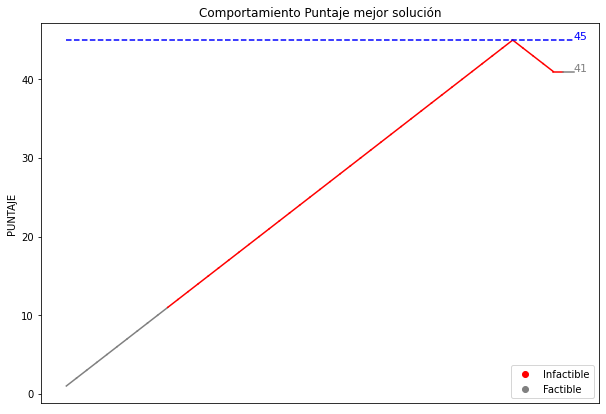

In [4]:
##  EJECUCIÓN  ###############################################################################################################

solucion=GRASP(10,0.84,0.5)
max_v=solucion[0]
max_t=solucion[1]
r0=solucion[2]
r1=solucion[3]
r2=solucion[4]
r3=solucion[5]
D=solucion[6]
graficar(max_v,max_t,r0,r1,r2,r3,D)